# RPC Log Analysis

## Functionalities
- Plot number of RPCs per second.
- Plot instantaneous latency of RPCs.
- Plot latency distribution of RPCs.

## Input
Log files are read from a directory in `../data`. This directory is assumed to have the following structure:
```
logs/
  [node-1]/
    *_service*.tar.gz
    ...
    apigateway*.tar.gz
  ...
  [node-n]/
    *_service*.tar.gz
    ...
    apigateway*.tar.gz
```
These tarballs contain RPC log files named `calls.log`.

## Notebook Configuration

In [1]:
########## GENERAL
# Name of the directory in `../data`
EXPERIMENT_DIRNAME = "BuzzBlogBenchmark_2021-11-23-16-32-52"

########## LATENCY
# Max expected value
MAX_LATENCY_IN_S = 1
# Bin size
LATENCY_BIN_IN_MS = 1

## Notebook Setup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath(os.path.join("..")))
from parsers.rpc_parser import RPCParser
from utils.utils import *

## Log Parsing

In [3]:
# Build data frame
rpc = pd.concat(
        [pd.DataFrame.from_dict(RPCParser(logfile).parse()) for logfile in get_rpc_logfiles(EXPERIMENT_DIRNAME)],
        ignore_index=True)

In [4]:
# (Re) Build columns
start_time = get_experiment_start_time(EXPERIMENT_DIRNAME)
rpc["timestamp"] = rpc.apply(lambda r: (r["timestamp"] - start_time).total_seconds(), axis=1)
rpc["window"] = rpc.apply(lambda r: int(r["timestamp"]), axis=1)

In [5]:
# (Re) Create index
rpc.set_index("timestamp", inplace=True)

In [6]:
# Get values
function_names = sorted(rpc["function"].unique())

## Number of RPCs per Second

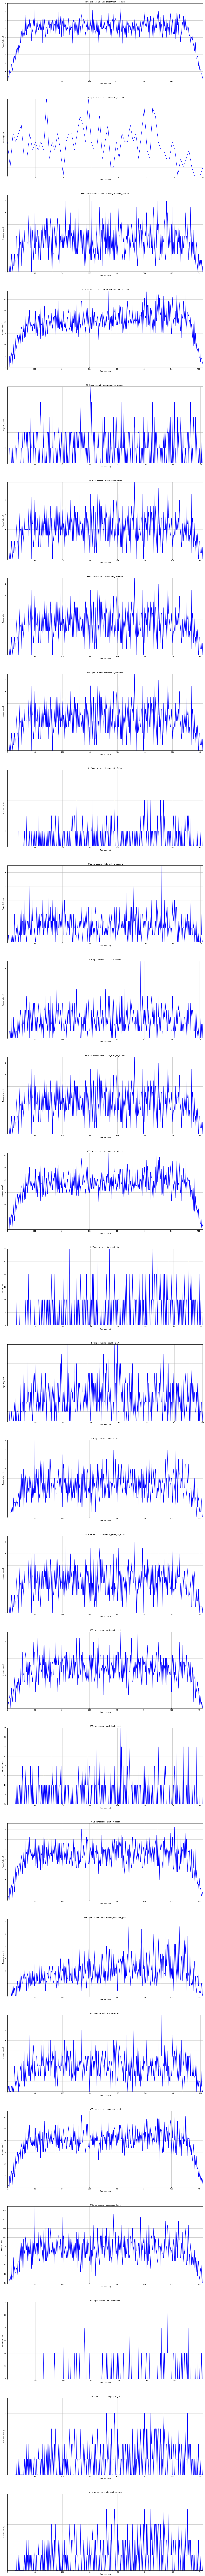

In [7]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = None
# Maximum time (in seconds)
MAX_TIME = None

# Plot
fig = plt.figure(figsize=(24, len(function_names) * 12))
for (i, function) in enumerate(function_names):
    df = rpc[(rpc["function"] == function)]
    if MIN_TIME:
        df = df[(df.index >= MIN_TIME)]
    if MAX_TIME:
        df = df[(df.index <= MAX_TIME)]
    df = df.groupby(["window"])["window"].count()
    df = df.reindex(range(int(df.index.min()), int(df.index.max()) + 1), fill_value=0)
    ax = fig.add_subplot(len(function_names), 1, i + 1)
    ax.grid(alpha=0.75)
    ax.set_xlim((MIN_TIME or 0, MAX_TIME or int(df.index.max())))
    ax.set_ylim((0, int(df.values.max())))
    df.plot(ax=ax, kind="line", title="RPCs per second - %s" % function, xlabel="Time (seconds)",
        ylabel="Requests (count)", color="blue", grid=True)
    plt.subplots_adjust(hspace=0.25)

## Instantaneous Latency of RPCs

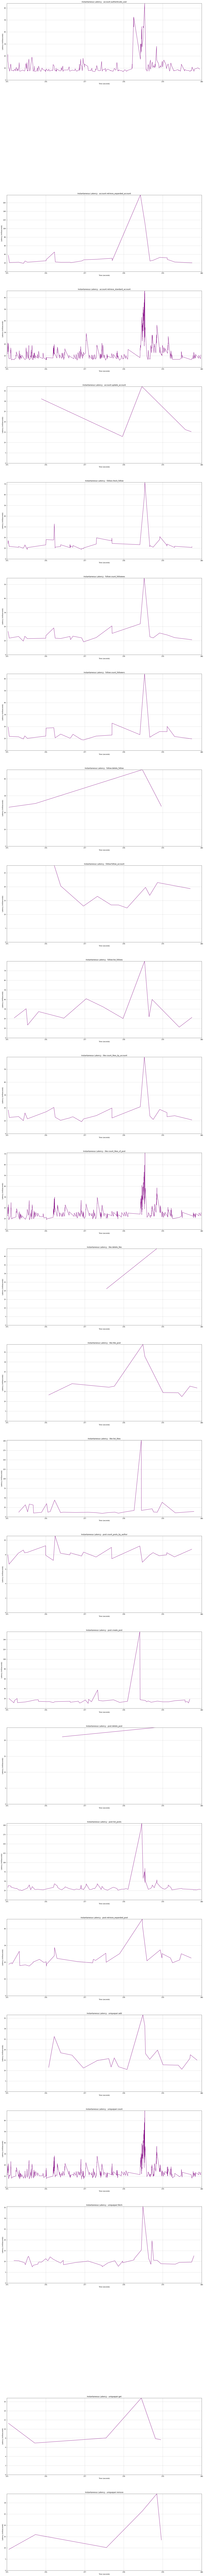

In [12]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = 375
# Maximum time (in seconds)
MAX_TIME = 380

# Plot
fig = plt.figure(figsize=(24, len(function_names) * 12))
for (i, function) in enumerate(function_names):
    df = rpc[(rpc["function"] == function)]
    if MIN_TIME:
        df = df[(df.index >= MIN_TIME)]
    if MAX_TIME:
        df = df[(df.index <= MAX_TIME)]
    if df.empty:
        continue
    df.sort_index(inplace=True)
    ax = fig.add_subplot(len(function_names), 1, i + 1)
    ax.grid(alpha=0.75)
    ax.set_xlim((MIN_TIME or 0, MAX_TIME or int(df.index.max())))
    ax.set_ylim((0, df["latency"].max()))
    df["latency"].plot(ax=ax, kind="line", title="Instantaneous Latency - %s" % function, xlabel="Time (seconds)",
        ylabel="Latency (milliseconds)", color="purple", grid=True)
    plt.subplots_adjust(hspace=0.25)

## Latency Distribution of RPCs

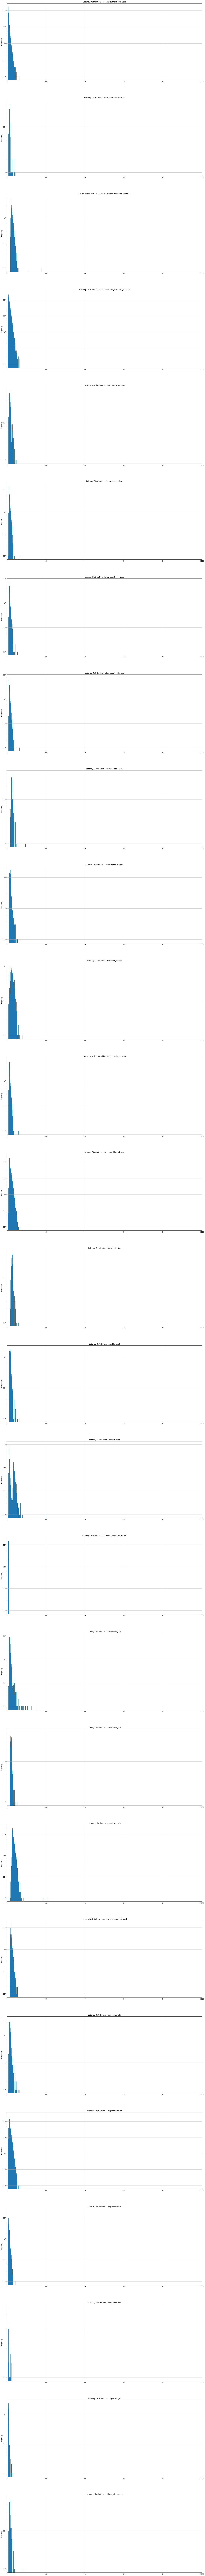

In [9]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = None
# Maximum time (in seconds)
MAX_TIME = None

# Plot
fig = plt.figure(figsize=(24, len(function_names) * 12))
for (i, function) in enumerate(function_names):
    df = rpc[(rpc["function"] == function)]
    if MIN_TIME:
        df = df[(df.index >= MIN_TIME)]
    if MAX_TIME:
        df = df[(df.index <= MAX_TIME)]
    if not len(df):
        continue
    df["latency_bin"] = df.apply(lambda r: int(r["latency"] // LATENCY_BIN_IN_MS), axis=1)
    ax = fig.add_subplot(len(function_names), 1, i + 1)
    ax.set_yscale("log")
    ax.grid(alpha=0.75)
    ax.set_xlim((0, (1000 // LATENCY_BIN_IN_MS) * MAX_LATENCY_IN_S))
    df["latency_bin"].plot(ax=ax, kind="hist", title="Latency Distribution - %s" % function,
        xlabel="Latency (milliseconds)", ylabel="Requests (count)",
        bins=range((1000 // LATENCY_BIN_IN_MS) * MAX_LATENCY_IN_S), grid=True)
    plt.subplots_adjust(hspace=0.25)

## Statistics

In [10]:
for (i, function) in enumerate(function_names):
    df = rpc[(rpc["function"] == function)]
    print(function)
    print("  Number of RPCs/s")
    print("    Total:       %7d" % df.shape[0])
    print("    Avg:         %7.2f" % (df.shape[0] / (df.index.max() - df.index.min())))
    print("  Latency (ms)")
    print("  P99.9:         %7.2f" % (df["latency"].quantile(0.999)))
    print("    P99:         %7.2f" % (df["latency"].quantile(0.99)))
    print("    P95:         %7.2f" % (df["latency"].quantile(0.95)))
    print("    P50:         %7.2f" % (df["latency"].quantile(0.50)))
    print("    Avg:         %7.2f" % (df["latency"].mean()))
    print("    Std:         %7.2f" % (df["latency"].std()))

account:authenticate_user
  Number of RPCs/s
    Total:         41720
    Avg:           58.36
  Latency (ms)
  P99.9:           35.21
    P99:           23.47
    P95:           16.41
    P50:            8.37
    Avg:            9.84
    Std:            3.47
account:create_account
  Number of RPCs/s
    Total:           256
    Avg:            3.63
  Latency (ms)
  P99.9:           54.65
    P99:           37.90
    P95:           22.62
    P50:           14.04
    Avg:           14.63
    Std:            5.51
account:retrieve_expanded_account
  Number of RPCs/s
    Total:          3583
    Avg:            5.06
  Latency (ms)
  P99.9:           57.22
    P99:           44.87
    P95:           36.66
    P50:           23.66
    Avg:           25.64
    Std:            6.14
account:retrieve_standard_account
  Number of RPCs/s
    Total:        139583
    Avg:          195.86
  Latency (ms)
  P99.9:           40.86
    P99:           29.32
    P95:           21.92
    P50:           10.